## Deep Causal Variational Inference
### Abstract
In this project we refractored the provided program for Causal Variational AutoEncoders such that there is a causal relationship between the latent variables as mentioned in the dataset. Once retained, we will apply various interventions to elements of the program and have that generate a new image that reflects that intervention. We aim to apply various counterfactual queries on our dataset and observe whether the reconstruction works appropriately.


### Dataset:
To train a supervised variational autoencoder using Deepmind's [dSprites](https://github.com/deepmind/dsprites-dataset) dataset.

dSprites is a dataset of sprites, which are 2D shapes procedurally generated from 5 ground truth independent "factors." These factors are color, shape, scale, rotation, x and y positions of a sprite.

All possible combinations of these variables are present exactly once, generating N = 737280 total images.

Factors and their values:

* Shape: 3 values {square, ellipse, heart}
* Scale: 6 values linearly spaced in (0.5, 1)
* Orientation: 40 values in (0, 2$\pi$)
* Position X: 32 values in (0, 1)
* Position Y: 32 values in (0, 1)


Further, the objective of any generative model is essentially to capture underlying data generative factors, the disentangled representation would mean a single latent unit being sensitive to variations in single generative factors

## Goal
The goal is to apply counterfactual queries on our dataset and observe the reconstructed images and results

Reference 

[Structured Disentangled Representation](https://arxiv.org/pdf/1804.02086.pdf)

### Dependencies

We will require several dependencies to install several packages to get the project working. We will be essentially requiring several packages like - 
* **Pyro Package** -  pyro is used for Deep Probabilistic Programming.
* **Torch Vision Package** - The torchvision package consists of popular datasets, 
model architectures, and common image transformations for computer vision.
* **Pydrive Package** - File management made easy. Upload/update the file with one method. PyDrive will do it in the most efficient way.
* **Tqdm Package** - tqdm package is used to plot user-interactive plot used for visualization.

In [3]:
!pip install -r requirements.txt

     |████████████████████████████████| 522kB 3.4MB/s 
  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=a1898cf62a47e008492c10689dd749584245bb443032f50725c382d73e8662fd
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


### Required Libraries
We will be importing various libraries and packages to work on with in Causal Variational AutoEncoder Implementation. 


In [0]:
# LOADING NECESSARY LIBRARIES

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import os
from collections import defaultdict

import torch
import torch.nn as nn

from tqdm import tqdm
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, EmpiricalMarginal
from pyro.optim import Adam, SGD
import torch.distributions.constraints as constraints

# Change figure aesthetics

%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#to utilize GPU capabilities

USE_CUDA = True
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

In [5]:
# Mount Google drive to load data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### GPU Compatibility
The project is made to be GPU compatible as the dataset comprises 737280 images of 64 x 64 dimensions each. Training of these images using neural network architecture would require a lot of time without GPU compatibility. We allocated the GPU using packages like psutil, humanize and gputil packages. Hereby, we will attach the code snippet which walks us through the code which will perform GPU allocation with ease.

In [6]:
# Hack to get all available GPU ram.

import tensorflow as tf
tf.test.gpu_device_name()

# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 24.3 GB  | Proc size: 3.3 GB
GPU RAM Free: 15477MB | Used: 803MB | Util   5% | Total 16280MB


### Encoder and Decoder

***Variational AutoEncoders*** are powerful data generative models. They are made up of multilayer perceptrons or feedforward networks where the provided activation parameter is used on every linear layer except for the output layer where we use the provided output activation parameter. 
They consist of two main components:

1.   Encoder
2.   Decoder

We have implemented them in our code using 3 layer neural networks in each. 

> The ***encoder*** class is used for converting the input image into latent variable. It takes in as input the image(xs) and the label(ys) and after processing through the forward function it gives as output the z_loc and z_scale values.
> These are the mean and variance values which are used in sampling the latent variable(zs) from a normal distribution. 

>The **decoder** class is used for decoding the image from the latent variables. It takes in as input the latent variable(zs) and the image label(ys). After passing these values through the neural network it reconstructs a new image which resembles very closely to the input image after training the variational autoencoder.  


In [0]:
class Encoder(nn.Module):
	"""
    MLPs (multi-layered perceptrons or simple feed-forward networks)
    where the provided activation parameter is used on every linear layer except
    for the output layer where we use the provided output_activation parameter
	"""
	def __init__(self, image_dim, label_dim, z_dim):
		super(Encoder, self).__init__()
		#setup image and label dimensions from the dataset
		self.image_dim = image_dim
		self.label_dim = label_dim
		self.z_dim = z_dim
		# setup the three linear transformations used
		self.fc1 = nn.Linear(self.image_dim+self.label_dim, 1000)
		self.fc2 = nn.Linear(1000, 1000)
		self.fc31 = nn.Linear(1000, z_dim)  # mu values
		self.fc32 = nn.Linear(1000, z_dim)  # sigma values
		# setup the non-linearities
		self.softplus = nn.Softplus()

	#Explaination: xs:- shape: [1, 4096] flattened 64*64 image; ys:- shape[1, 114] flattended one hot encoded values of 6 labels
	def forward(self, xs, ys):
		xs = xs.reshape(-1, self.image_dim)
		#now concatenate the image and label
		inputs = torch.cat((xs,ys), -1)
		# then compute the hidden units
		hidden1 = self.softplus(self.fc1(inputs))
		hidden2 = self.softplus(self.fc2(hidden1))
		# then return a mean vector and a (positive) square root covariance
		# each of size batch_size x z_dim
		z_loc = self.fc31(hidden2)
		z_scale = torch.exp(self.fc32(hidden2))
		return z_loc, z_scale


class Decoder(nn.Module):
	def __init__(self, image_dim, label_dim, z_dim):
		super(Decoder, self).__init__()
		# setup the two linear transformations used
		hidden_dim = 1000
		self.fc1 = nn.Linear(z_dim+label_dim, hidden_dim)
		self.fc2 = nn.Linear(hidden_dim, hidden_dim)
		self.fc3 = nn.Linear(hidden_dim, hidden_dim)
		self.fc4 = nn.Linear(hidden_dim, image_dim)
		# setup the non-linearities
		self.softplus = nn.Softplus()
		self.sigmoid = nn.Sigmoid()

	def forward(self, zs, ys):
		inputs = torch.cat((zs, ys),-1)
		# then compute the hidden units
		hidden1 = self.softplus(self.fc1(inputs))
		hidden2 = self.softplus(self.fc2(hidden1))
		hidden3 = self.softplus(self.fc3(hidden2))
		# return the parameter for the output Bernoulli
		# each is of size batch_size x 784
		loc_img = self.sigmoid(self.fc4(hidden3))
		return loc_img

### Causal Variational AutoEncoder (CVAE)

This module implements the Causal Effect Variational Autoencoder [1], which demonstrates a number of innovations including:


*   a generative model for causal effect inference with hidden confounders;
*   a model and guide with twin neural nets to allow imbalanced treatment,




class *Model*

Generative model for a causal model with latent confounder z and binary treatment t:

    z ~ p(z)      # latent confounder

    x ~ p(x|z)    # partial noisy observation of z

    t ~ p(t|z)    # treatment, whose application is biased by z

    y ~ p(y|t,z)  # outcome

Each of these distributions is defined by a neural network. The y distribution is defined by a disjoint pair of neural networks defining p(y|t=0,z) and p(y|t=1,z); this allows highly imbalanced treatment.

class *Guide*

Inference model for causal effect estimation with latent confounder z and binary treatment t:

    t ~ p(t|x)      # treatment

    y ~ p(y|t,x)    # outcome

    z ~ p(t|y,t,x)  # latent confounder, an embedding

Each of these distributions is defined by a neural network. The y and z distributions are defined by disjoint pairs of neural networks defining p(-|t=0,...) and p(-|t=1,...); this allows highly imbalanced treatment.



*   a custom training loss that includes both ELBO terms and extra terms needed to  train the guide to be able to answer counterfactual queries.

The main interface is the CEVAE class, but users may customize by using components Model, Guide, TraceCausalEffect_ELBO and utilities.






In [0]:
#Explaination: Shapes:- xs: [1, image_dim(4096)], ys: [1, label_dim(114)], zs: [1, z_dim(50)]
class CVAE(nn.Module):
	"""
	This class encapsulates the parameters (neural networks) and models & guides 
	needed to train a supervised variational auto-encoder 
	"""
	def __init__(self, config_enum=None, use_cuda=False, aux_loss_multiplier=None):
    
		super(CVAE, self).__init__()
		self.image_dim = 64**2
		self.label_shape = np.array((1,3,6,40,32,32))
		self.label_names = np.array(('color', 'shape', 'scale', 'orientation', 'posX', 'posY'))
		self.label_dim = np.sum(self.label_shape)
		self.z_dim = 50                                           
		self.allow_broadcast = config_enum == 'parallel'
		self.use_cuda = use_cuda
		self.aux_loss_multiplier = aux_loss_multiplier
	    # define and instantiate the neural networks representing
	    # the paramters of various distributions in the model
		self.setup_networks()

	def setup_networks(self):
		"""
		Setup and initialize Encoder and decoder units
		"""
		self.encoder = Encoder(self.image_dim, self.label_dim, self.z_dim)
		self.decoder = Decoder(self.image_dim, self.label_dim, self.z_dim)
		# using GPUs for faster training of the networks
		if self.use_cuda:
		    self.cuda()

	def model(self, xs, ys):
		pyro.module("cvae", self)
		batch_size = xs.size(0)
		options = dict(dtype=xs.dtype, device=xs.device)
		with pyro.plate("data"):
			prior_loc = torch.zeros(batch_size, self.z_dim, **options)
			prior_scale = torch.ones(batch_size, self.z_dim, **options)
			zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))
			# if the label y (which digit to write) is supervised, sample from the
			# constant prior, otherwise, observe the value (i.e. score it against the constant prior)
			loc = self.decoder.forward(zs, self.remap_y(ys))
			pyro.sample("x", dist.Bernoulli(loc).to_event(1), obs=xs)
		  	# return the loc so we can visualize it later
			return loc

	def guide(self, xs, ys):
		with pyro.plate("data"):
			# sample (and score) the latent handwriting-style with the variational
			# distribution q(z|x) = normal(loc(x),scale(x))
			loc, scale = self.encoder.forward(xs, self.remap_y(ys))
			pyro.sample("z", dist.Normal(loc, scale).to_event(1))

	#Explaination: Kind of one hot encodes each labels of ys. ys size: 6. size of each label: 1+3+6+40+32+32. new_ys size: 114. new_ys contains 1 at particular place of value of that label in ys 
	def remap_y(self, ys):
		new_ys = []
		options = dict(dtype=ys.dtype, device=ys.device)
		for i, label_length in enumerate(self.label_shape):
		    prior = torch.ones(ys.size(0), label_length, **options) / (1.0 * label_length)
		    new_ys.append(pyro.sample("y_%s" % self.label_names[i], dist.OneHotCategorical(prior), 
		                           obs=torch.nn.functional.one_hot(ys[:,i].to(torch.int64), int(label_length))))
		new_ys = torch.cat(new_ys, -1)
		return new_ys.to(torch.float32)

	#Explaination: Reconstruct decoded image using a VAE by using an original image and its label
	def reconstruct_image(self, xs, ys):
		# backward
		sim_z_loc, sim_z_scale = self.encoder.forward(xs, self.remap_y(ys))
		zs = dist.Normal(sim_z_loc, sim_z_scale).to_event(1).sample()
		# forward
		loc = self.decoder.forward(zs, self.remap_y(ys))
		return dist.Bernoulli(loc).to_event(1).sample()

### Data Setup
We will be splitting our dataset in test and train data both for the images and the labels. The image will be split into test and train images. Also, we have 6 types of labels for a single image therefore, we split the label as well in the similar format and store them in a dictionary inside the data_loader function. The code snippet here explains how this dataset is combined and stored in the data_loader dictionary. The important thing here to notice is how the labels and individual images are combined within the train and the test keys of the dictionary formed.

In [0]:
def setup_data_loaders(train_x, test_x, train_y, test_y, batch_size=128, use_cuda=False):
	train_dset = torch.utils.data.TensorDataset(
	  torch.from_numpy(train_x.astype(np.float32)).reshape(-1, 4096),
	  torch.from_numpy(train_y.astype(np.float32))
	)
	test_dset = torch.utils.data.TensorDataset(
	  torch.from_numpy(test_x.astype(np.float32)).reshape(-1, 4096),
	  torch.from_numpy(test_y.astype(np.float32))
	)    
	kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
	train_loader = torch.utils.data.DataLoader(
	  dataset=train_dset, batch_size=batch_size, shuffle=False, **kwargs
	)

	test_loader = torch.utils.data.DataLoader(
	  dataset=test_dset, batch_size=batch_size, shuffle=False, **kwargs
	)
	return {"train":train_loader, "test":test_loader}

### Data Loading

 We will now load the dataset into the Google Colab form our drive. The link for the dataset should be changed based on the location of the dataset within an individual drive. We will be then creating the set of sampled images from the loaded dataset, along with labels sampled. Once the dataset is loaded into the Colab, which eventually will take some time as due to the size of the dataset. We then call the setup_data_loaders function to prepare the data loaders dictionary. The data loaders dictionary will comprise of the train and the test data in appropriate format with labels attached.

In [0]:
dataset_zip = np.load(
    '/content/gdrive/My Drive/CausalML_VAE/data/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',
    encoding = 'bytes',
    allow_pickle=True
)

imgs = dataset_zip['imgs']
labels = dataset_zip['latents_classes']
label_sizes = dataset_zip['metadata'][()][b'latents_sizes']
label_names = dataset_zip['metadata'][()][b'latents_names']

# Sample imgs randomly
indices_sampled = np.arange(imgs.shape[0])
np.random.shuffle(indices_sampled)
imgs_sampled = imgs[indices_sampled]
labels_sampled = labels[indices_sampled]

## Sampled Images of Dimension (737280, 64, 64) and Labels Dimension (737280, 6)

data_loaders = setup_data_loaders(
    imgs_sampled[1000:],
    imgs_sampled[:1000],
    labels_sampled[1000:],
    labels_sampled[:1000],
    batch_size=256,
    use_cuda=USE_CUDA
)


### Training the Dataset on CVAE Model

# Loss Functions on Train and Test Dataset

We have used the SVI (Stochastic Variational Inference) in Pyro to compute the losses from the train and the test dataset. We will be using svi.step for observing the loss for the train data and svi.evaluate for observing the loss for test dataset.
Details for the SVI.step and SVI.evaluate from pyro documentation - 

The SVI object provides two methods, step() and evaluate_loss(), that encapsulate the logic for variational learning and evaluation:



1.   The method svi.step() takes a single gradient step and returns an estimate of the loss (i.e. minus the ELBO). If provided, the arguments to step() are piped to model() and guide().
2.   The method svi.evaluate_loss() 
returns an estimate of the loss without taking a gradient step. Just like for step(), if provided, arguments to evaluate_loss() are piped to model() and guide()

In [0]:
# Loss function for train Data

def train(svi, train_loader, use_cuda=False):
	# initialize loss accumulator
	epoch_loss = 0.
	# do a training epoch over each mini-batch x returned
	# by the data loader
	for xs,ys in train_loader:
	  # if on GPU put mini-batch into CUDA memory
	  if use_cuda:
	      xs = xs.cuda()
	      ys = ys.cuda()
	  # do ELBO gradient and accumulate loss
	  epoch_loss += svi.step(xs, ys)
	# return epoch loss
	normalizer_train = len(train_loader.dataset)
	total_epoch_loss_train = epoch_loss / normalizer_train
	return total_epoch_loss_train

# Loss function for test data

def evaluate(svi, test_loader, use_cuda=False):
	# initialize loss accumulator
	test_loss = 0.
	# compute the loss over the entire test set
	for xs, ys in test_loader:
	  # if on GPU put mini-batch into CUDA memory
	  if use_cuda:
	      xs = xs.cuda()
	      ys = ys.cuda()
	  # compute ELBO estimate and accumulate loss
	  test_loss += svi.evaluate_loss(xs, ys)
	normalizer_test = len(test_loader.dataset)
	total_epoch_loss_test = test_loss / normalizer_test
	return total_epoch_loss_test

# Hyperparameters used for Training the Model

The Hyperparameters used for the optimal working of the model is the learning rate and the number of epochs. We used the learning rate of **1.0e-3** and the number of epochs are **10**. The following hyperparameter gave the best results for the model.


In [0]:
# Declaring parameters to train the model
# Run options
LEARNING_RATE = 1.0e-3

# Run only for a single iteration for testing
NUM_EPOCHS = 10
TEST_FREQUENCY = 5

### Training the Model



1.   We have trained the dataset by setting up the SVI inference algorithm. The model and the guide are used from the VAE class. We have used an **Adam** optimizer as they perform the best for stochastic data 
2.  We then use the svi.step and svi.evaluate to compute the losses for the train and test data and keep a check whether the model is performing well.



In [14]:
import warnings
warnings.filterwarnings('ignore')

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = CVAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop

VERBOSE = True
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    total_epoch_loss_train = train(svi, data_loaders["train"], use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    if VERBOSE:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loaders["test"], use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        if VERBOSE:
            print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

  0%|          | 0/10 [00:00<?, ?it/s]

[epoch 000]  average training loss: 167.4154


 10%|█         | 1/10 [00:59<08:56, 59.66s/it]

[epoch 000] average test loss: 102.0709


 20%|██        | 2/10 [01:58<07:55, 59.46s/it]

[epoch 001]  average training loss: 77.0416


 30%|███       | 3/10 [02:57<06:54, 59.28s/it]

[epoch 002]  average training loss: 64.1255


 40%|████      | 4/10 [03:55<05:54, 59.02s/it]

[epoch 003]  average training loss: 42.4773


 50%|█████     | 5/10 [04:54<04:53, 58.80s/it]

[epoch 004]  average training loss: 33.2054
[epoch 005]  average training loss: 25.0997


 60%|██████    | 6/10 [05:51<03:53, 58.49s/it]

[epoch 005] average test loss: 21.8711


 70%|███████   | 7/10 [06:49<02:54, 58.20s/it]

[epoch 006]  average training loss: 20.2512


 80%|████████  | 8/10 [07:47<01:56, 58.17s/it]

[epoch 007]  average training loss: 18.8102


 90%|█████████ | 9/10 [08:44<00:57, 57.94s/it]

[epoch 008]  average training loss: 17.6850


100%|██████████| 10/10 [09:42<00:00, 58.20s/it]

[epoch 009]  average training loss: 16.8149


### Saving the model for Reusability

We also saved the weights for the trained model in a file to enable the reusability as it would take a lot of time to rerun the training iteratively. Therefore, to overcome this issue we can save the weights once the training is completed and then reuse the weights merely by loading them again. This saves a lot of time and ensures the reusability of the model.


### Saving the Model

In [0]:
#################################
### FOR SAVING AND LOADING MODEL
################################
# clear param store

pyro.clear_param_store()

network_path = "/trained_model.save"
torch.save(vae.state_dict(), network_path)

### Loss Plot 

We can clearly observe from the loss plot in the image attached below, that the given hyperparameters used are performing well, as after 10 epochs there is no significant change in the training losses and thus we achieved average training loss of 16.92 and average test loss of 20.43 from our code.


Text(0.5, 1.0, 'ELBO Plot for Train Data')

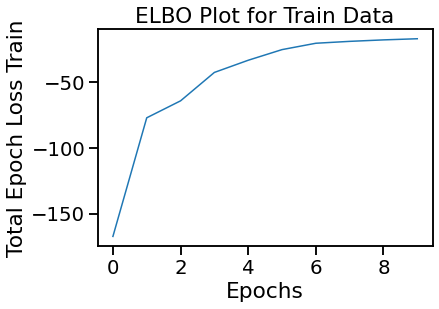

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_elbo)
plt.xlabel("Epochs")
plt.ylabel("Total Epoch Loss Train")

plt.title("ELBO Plot for Train Data")

In [0]:
######LOADING THE SAVED MODEL#############
network_path = "/trained_model.save"

vae=CVAE(use_cuda=USE_CUDA)
vae.load_state_dict(torch.load(network_path))

<All keys matched successfully>

## Visualizing the reconstruction accuracy of VAE

Explaination: [2 cells] Checking and comparing original image with the one reconstructed from decoder

In [16]:
import warnings
warnings.filterwarnings("ignore")

data_iter = iter(data_loaders["train"])

xs, ys = next(data_iter)
print(xs.shape, ys.shape)
if USE_CUDA:
    xs = xs.cuda()
    ys = ys.cuda()

# Call to Reconstruct the Images from the Decoder
rs = vae.reconstruct_image(xs, ys)

if USE_CUDA:
    xs = xs.cpu()
    rs = rs.cpu()
# Original Image
originals = xs.numpy().reshape(-1, 64,64)

# Reconstructed Image from VAE
recons = rs.reshape(-1,64,64)

torch.Size([256, 4096]) torch.Size([256, 6])


In [17]:
# f(x) plots the given image possibilities that is its variation observed with a given label which here is shape
def f(x):
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(originals[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    ax1 = fig.add_subplot(122)
    plt.imshow(recons[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    
interact(f, x=widgets.IntSlider(min=0, max=xs.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='x', max=255), Output()), _dom_classes=('widget-interact'…

<function __main__.f>

Explaination: [1 Cell] Sampled Images of the datset- All possible combination of dsprite images
(Nothing to do with encoder-decoder or CVAE or anything)

In [18]:
y_names = ['shape', 'scale', 'orientation', 'posX', 'posY']
y_shapes = np.array((3,6,40,32,32))
img_dict = {}

for i, img in enumerate(imgs_sampled):
     img_dict[tuple(labels_sampled[i])] = img

# print(img_dict)
def find_in_dataset(shape, scale, orient, posX, posY):
  fig = plt.figure()
  img = img_dict[(0, shape, scale, orient, posX, posY)]
  plt.imshow(img.reshape(64,64), cmap='Greys_r', interpolation='nearest')
  plt.axis('off')

interact(find_in_dataset, 
         shape=widgets.IntSlider(min=0, max=2, step=1, value=0),
         scale=widgets.IntSlider(min=0, max=5, step=1, value=0),
         orient=widgets.IntSlider(min=0, max=39, step=1, value=0),
         posX=widgets.IntSlider(min=0, max=31, step=1, value=0),
         posY=widgets.IntSlider(min=0, max=31, step=1, value=0))

interactive(children=(IntSlider(value=0, description='shape', max=2), IntSlider(value=0, description='scale', …

<function __main__.find_in_dataset>

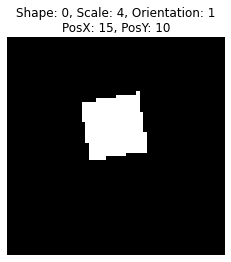

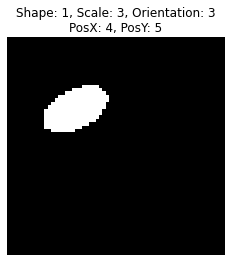

In [19]:
def get_specific_data(args=dict(), cuda=False):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        cuda - bool to indicate whether the output should be placed on GPU
    '''
    
    names_dict = {'shape': 1, 'scale': 2, 'orientation': 3, 'posX': 4, 'posY': 5}
    selected_ind = np.ones(imgs.shape[0], dtype=bool)
    for k,v in args.items():
        col_id = names_dict[k]
        selected_ind = np.bitwise_and(selected_ind, labels[:, col_id] == v)
    # print(selected_ind)
    ind = np.random.choice(np.arange(imgs.shape[0])[selected_ind])
    # print(ind)
    x = torch.from_numpy(imgs[ind].reshape(1,64**2).astype(np.float32))
    y = torch.from_numpy(labels[ind].reshape(1,6).astype(np.float32))
    if not cuda:
        return x,y
    x = x.cuda()
    y = y.cuda()
    return x,y

def plot_image(x):
    """
    helper to plot dSprites images
    """
    x = x.cpu()
    plt.figure()
    plt.imshow(x.reshape(64,64), interpolation='nearest', cmap='Greys_r')
    plt.axis('off')

def see_specific_image(args=dict(), verbose=True):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        verbose - bool to indicate whether the full class label should be written 
                    as the title of the plot
    '''
    x,y = get_specific_data(args, cuda=False)
    plot_image(x)
    if verbose:
        string = ''
        for i, s in enumerate(['Shape', 'Scale', 'Orientation', 'PosX', 'PosY']):
            string += '%s: %d, ' % (s, int(y[0][i+1]))
            if i == 2:
                string = string[:-2] + '\n'
        plt.title(string[:-2], fontsize=12)

    
def compare_to_density(original, recons):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array of multiple recon images
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(torch.mean(recons.cpu(), 0).reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstructions')

#See random image
see_specific_image()
#See specific image        
see_specific_image({'shape': 1, 'scale': 3, 'orientation': 3, 'posX': 4, 'posY': 5})

In [20]:
label_dims = vae.label_shape
label_dim_offsets = np.cumsum(label_dims)
label_dim_offsets

array([  1,   4,  10,  50,  82, 114])

## Structural Causal Model

We implemented a Structural causal model capturing the causal dependencies of the endogenous and exogenous variables in our model. An object of class SCM() takes in 3 arguments, an instance of a VAE, loc of q(z|x) given by the VAE encoder, and the sigma of q(z|x) also given by the VAE encoder. 

The endogenous variables in our model are of 3 types:-
 dSprite image(X), 
 
 labels corresponding to the image(Y), 
 
 and the latent variable(Z) sampled from a normal distribution with mean and variance returned by the variational autoencoder. Here Y is further subdivided into 5 variables ‘Y_1’, ‘Y_2’, ‘Y_3’, ‘Y_4’, and ‘Y_5’. Each of these variables represents the individual image label. The exogenous variables in our SCM are represented by noises corresponding to each of the endogenous variables with a suffix ‘N_’.

There are two main functions in the SCM class:
1. model:


> This function corresponds to a data generative process. It takes in input as argument the noise variables i.e the exogenous variables and returns X(image), Y(labels), and Z(latents). 
> It does so by sampling the individual endogenous variables using a normal probability distribution.


2. updated_noise_svi


> This function takes in as input the labels of an image in the form of a dictionary (obs_data), and an optional intervened model(intervened_model) and returns the exogenous variables or noises corresponding to the images referred by obs_data. 

> It uses SVI to find out the mu and sigma of the distribution for the conditions outlined in obs_data.

It has has a guide function which serves as an approximation to the posterior p(z|x). The guide provides a valid joint probability density over all the latent random variables in the model.

Once the guide is specified and the model is conditioned, we move to the inference step. Now, this is an optimization problem where each iteration of training takes a step that moves the guide closer to the exact posterior.



In [0]:
#Explaination: While creating object, takes as input the mu, sigma values generated from an encoder
class SCM():
    """
    Structural causal model
    
    args: 
      vae: instance of vae
      mu: loc of q(z|x) given by the vae encoder
      sigma: scale of q(z|x) given by the vae encoder
    
    """
    def __init__(self, vae, mu, sigma):
        """
        Constructor
        
        Intializes :
          image dimensions - 4096(64*64), 
          z dimensions: size of the tensor representing the latent random variable z, 
          label dimensions: 114 labels y that correspond to an image(one hot encoded)
          f(x) = p(x|y,z)
          Noise variables in the model N_#
        """
        self.vae = vae
        self.image_dim = vae.image_dim
        self.z_dim = vae.z_dim
        # these are used for f_X
        self.label_dims = vae.label_shape
        
        def f_X(Y, Z, N):
            """
            Generating one hots for the factors
            """ 
            zs = Z.cuda()
            # convert the labels to one hot
            ys = [torch.tensor([0])]
            ys.append(torch.nn.functional.one_hot(torch.round(Y[0]).to(torch.long), int(self.label_dims[1])))
            ys.append(torch.nn.functional.one_hot(torch.round(Y[1]).to(torch.long), int(self.label_dims[2])))
            ys.append(torch.nn.functional.one_hot(torch.round(Y[2]).to(torch.long), int(self.label_dims[3])))
            ys.append(torch.nn.functional.one_hot(torch.round(Y[3]).to(torch.long), int(self.label_dims[4])))
            ys.append(torch.nn.functional.one_hot(torch.round(Y[4]).to(torch.long), int(self.label_dims[5])))
            ys = torch.cat(ys).to(torch.float32).reshape(1,-1).cuda()
            p = vae.decoder.forward(zs, ys)
            return (N < p.cpu()).type(torch.float)
        
        def f_Y(N):
            """
            Gumbel distribution - to model the distribution of the maximum of a number of samples
            m = Gumbel(torch.tensor([1.0]), torch.tensor([2.0])).sample() # sample from Gumbel distribution with loc=1, scale=2
            tensor([ 1.0124])
            
            https://pytorch.org/docs/stable/_modules/torch/distributions/gumbel.html
            """
            beta = 12
            indices = torch.tensor(np.arange(N.size(0))).to(torch.float32)
            smax = nn.functional.softmax(beta*N)
            argmax_ind = torch.sum(smax*indices)
            return argmax_ind
        
        def f_Z(N):
            """
            Z ~ Normal(mu, sigma) 
            """
            return N * sigma + mu
        
        def model(noise): 
            """
            The model corresponds to a generative process
            
            args: noise variables
            return: X(image), Y(labels), Z(latents) 
            """
            N_X = pyro.sample( 'N_X', noise['N_X'].to_event(1) )
            # denoted using the index in the sequence 
            # that they are stored in as vae.label_names:
            # ['shape', 'scale', 'orientation', 'posX', 'posY']
            N_Y_1 = pyro.sample( 'N_Y_1', noise['N_Y_1'].to_event(1) )
            N_Y_2 = pyro.sample( 'N_Y_2', noise['N_Y_2'].to_event(1) )
            N_Y_3 = pyro.sample( 'N_Y_3', noise['N_Y_3'].to_event(1) )
            N_Y_4 = pyro.sample( 'N_Y_4', noise['N_Y_4'].to_event(1) )
            N_Y_5 = pyro.sample( 'N_Y_5', noise['N_Y_5'].to_event(1) )
            
            # Z ~ Normal(Nx_mu, Nx_sigma)              
            N_Z = pyro.sample( 'N_Z', noise['N_Z'].to_event(1) )
            Z = pyro.sample('Z', dist.Normal( f_Z( N_Z ), 1e-1).to_event(1) )
       
            Y_1 = pyro.sample('Y_1', dist.Normal( f_Y(N_Y_1), 1e-2) )
            Y_2 = pyro.sample('Y_2', dist.Normal( f_Y(N_Y_2), 1e-1) )
            Y_3 = pyro.sample('Y_3', dist.Normal( f_Y(N_Y_3), 1e-1) )
            Y_4 = pyro.sample('Y_4', dist.Normal( f_Y(N_Y_4), 1e-1) )
            Y_5 = pyro.sample('Y_5', dist.Normal( f_Y(N_Y_5), 1e-1) )
            
            
            # X ~ p(x|y,z) = bernoulli(loc(y,z))             
            X = pyro.sample('X', dist.Normal( f_X( (Y_1, Y_2, Y_3,Y_4,Y_5), Z, N_X ), 1e-2).to_event(1))
            
            # return noise and variables
            noise_samples = N_X, (N_Y_1, N_Y_2, N_Y_3, N_Y_4, N_Y_5), N_Z
            variable_samples = X, (Y_1, Y_2, Y_3, Y_4, Y_5), Z
            return variable_samples, noise_samples
        
        self.model = model
        #Initialize all noise variables in the model         
        self.init_noise = {
            'N_X'   : dist.Uniform(torch.zeros(vae.image_dim), torch.ones(vae.image_dim)),
            'N_Z'   : dist.Normal(torch.zeros(vae.z_dim), torch.ones(vae.z_dim)),
            'N_Y_1' : dist.Uniform(torch.zeros(self.label_dims[1]),torch.ones(self.label_dims[1])),
            'N_Y_2' : dist.Uniform(torch.zeros(self.label_dims[2]),torch.ones(self.label_dims[2])),
            'N_Y_3' : dist.Uniform(torch.zeros(self.label_dims[3]),torch.ones(self.label_dims[3])),
            'N_Y_4' : dist.Uniform(torch.zeros(self.label_dims[4]),torch.ones(self.label_dims[4])),
            'N_Y_5' : dist.Uniform(torch.zeros(self.label_dims[5]),torch.ones(self.label_dims[5]))            
        }
        
    def update_noise_svi(self, obs_data, intervened_model=None):
        """
        Use svi to find out the mu, sigma of the distributions for the 
        condition outlined in obs_data
        """
        
        def guide(noise):
            """
            The guide serves as an approximation to the posterior p(z|x). 
            The guide provides a valid joint probability density over all the 
            latent random variables in the model.
            
            https://pyro.ai/examples/svi_part_i.html
            """
            # create params with constraints
            mu = {
                'N_X': pyro.param('N_X_mu', 0.5*torch.ones(self.image_dim),constraint = constraints.interval(0., 1.)),
                'N_Z': pyro.param('N_Z_mu', torch.zeros(self.z_dim),constraint = constraints.interval(-3., 3.)),
                'N_Y_1': pyro.param('N_Y_1_mu', 0.5*torch.ones(self.label_dims[1]),constraint = constraints.interval(0., 1.)),
                'N_Y_2': pyro.param('N_Y_2_mu', 0.5*torch.ones(self.label_dims[2]),constraint = constraints.interval(0., 1.)),
                'N_Y_3': pyro.param('N_Y_3_mu', 0.5*torch.ones(self.label_dims[3]),constraint = constraints.interval(0., 1.)),
                'N_Y_4': pyro.param('N_Y_4_mu', 0.5*torch.ones(self.label_dims[4]),constraint = constraints.interval(0., 1.)),
                'N_Y_5': pyro.param('N_Y_5_mu', 0.5*torch.ones(self.label_dims[5]),constraint = constraints.interval(0., 1.))
                }
            sigma = {
                'N_X': pyro.param('N_X_sigma', 0.1*torch.ones(self.image_dim),constraint = constraints.interval(0.0001, 0.5)),
                'N_Z': pyro.param('N_Z_sigma', torch.ones(self.z_dim),constraint = constraints.interval(0.0001, 3.)),
                'N_Y_1': pyro.param('N_Y_1_sigma', 0.1*torch.ones(self.label_dims[1]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_2': pyro.param('N_Y_2_sigma', 0.1*torch.ones(self.label_dims[2]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_3': pyro.param('N_Y_3_sigma', 0.1*torch.ones(self.label_dims[3]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_4': pyro.param('N_Y_4_sigma', 0.1*torch.ones(self.label_dims[4]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_5': pyro.param('N_Y_5_sigma', 0.1*torch.ones(self.label_dims[5]),constraint = constraints.interval(0.0001, 0.5))
                }
            for noise_term in noise.keys():
                pyro.sample(noise_term, dist.Normal(mu[noise_term], sigma[noise_term]).to_event(1))
        
        # Condition the model
        if intervened_model is not None:
          obs_model = pyro.condition(intervened_model, obs_data)
        else:
          obs_model = pyro.condition(self.model, obs_data)
          
        pyro.clear_param_store()

        # Once we’ve specified a guide, we’re ready to proceed to inference. 
        # Now, this an optimization problem where each iteration of training takes  
        # a step that moves the guide closer to the exact posterior 
        
        # https://arxiv.org/pdf/1601.00670.pdf
        svi = SVI(
            model= obs_model,
            guide= guide,
            optim= SGD({"lr": 1e-5, 'momentum': 0.1}),
            loss=Trace_ELBO(retain_graph=True)
        )
        
        num_steps = 1500
        samples = defaultdict(list)
        for t in range(num_steps):
            loss = svi.step(self.init_noise)
            for noise in self.init_noise.keys():
                mu = '{}_mu'.format(noise)
                sigma = '{}_sigma'.format(noise)
                samples[mu].append(pyro.param(mu).detach().numpy())
                samples[sigma].append(pyro.param(sigma).detach().numpy())
        means = {k: torch.tensor(np.array(v).mean(axis=0)) for k, v in samples.items()}
        
        # update the inferred noise
        updated_noise = {
            'N_X'  : dist.Normal(means['N_X_mu'], means['N_X_sigma']),
            'N_Z'  : dist.Normal(means['N_Z_mu'], means['N_Z_sigma']),
            'N_Y_1': dist.Normal(means['N_Y_1_mu'], means['N_Y_1_sigma']),
            'N_Y_2': dist.Normal(means['N_Y_2_mu'], means['N_Y_2_sigma']),
            'N_Y_3': dist.Normal(means['N_Y_3_mu'], means['N_Y_3_sigma']),
            'N_Y_4': dist.Normal(means['N_Y_4_mu'], means['N_Y_4_sigma']),
            'N_Y_5': dist.Normal(means['N_Y_5_mu'], means['N_Y_5_sigma']),
        }
        return updated_noise
        
    def __call__(self):
        return self.model(self.init_noise)

### Sanity Check on Working of CVAE

##Sanity Check [1]

Description - Make sure that the VAE is working properly. We will do this by generating a single image from the dataset and reconstructing it using sampling from VAE.

From the results in  the figure attached, we can observe that the Sanity Check [1] passed as we were able to generate the exact same image using the CVAE.

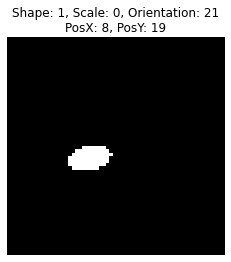

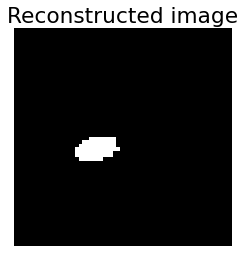

In [22]:
# Generate an instance of dSprites image 
ox, y = get_specific_data(cuda=True)
# Pass it through VAE to get q(z|x) => N(mu, sigma)
mu, sigma = vae.encoder.forward(ox,vae.remap_y(y))
# Feed these params to our custom SCM
scm = SCM(vae, mu.cpu(), sigma.cpu())
string = ''
for i, s in enumerate(['Shape', 'Scale', 'Orientation', 'PosX', 'PosY']):
    string += '%s: %d, ' % (s, int(y[0][i+1]))
    if i == 2:
        string = string[:-2] + '\n'
plot_image(ox)
plt.title(string[:-2], fontsize=12)
plt.show()
# Check for reconstruction
zs = dist.Normal(mu.cpu(), sigma.cpu()).to_event(1).sample()
loc = vae.decoder.forward(zs.cuda(), vae.remap_y(y))
recon = dist.Bernoulli(loc).to_event(1).sample()
recon = recon.reshape(64,64)
plt.imshow(recon.cpu(), cmap='Greys_r',  interpolation='nearest')
plt.axis('off')
plt.title('Reconstructed image')
plt.show()

### Sanity Check [2]
Description - To ensure proper functioning of the decoder, by checking the decoder is able to generate the images if the latents are changed manually. We will implement this by manually changing the latents in the code and run it through the decoder and check for the reconstruction.

 From the results attached in the figure, we can observe that we manually changed the shape of the original image from square to an oval, the decoder worked well and generated an oval without changing any other latent variable for the original image.



top original image with no change:  tensor([[ 0.,  1.,  0., 34.,  4., 12.]], device='cuda:0')
Middle with change in shape:  tensor([[ 0.,  0.,  0., 34.,  4., 12.]], device='cuda:0')
bottom with change in Orientation:  tensor([[ 0.,  0.,  0.,  1.,  4., 12.]], device='cuda:0')


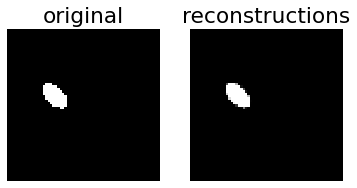

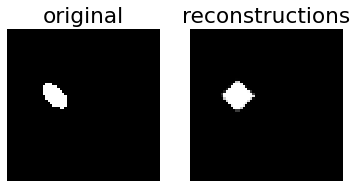

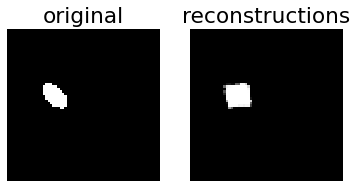

In [23]:
original, y_original = get_specific_data(cuda=True)
print('top original image with no change: ',y_original)
mu, sigma = vae.encoder.forward(original,vae.remap_y(y_original))
B = 100
#Explaination: here zs is being sampled 100 times with new values from distribution
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
#Explaination: here ys is being repeatedly 100 times assigned the same value
ys = torch.cat([vae.remap_y(y_original) for a in range(B)], 0)
rs = vae.decoder.forward(zs.cuda(), ys).detach()
compare_to_density(original,rs)

y_new = torch.tensor(y_original)

y_new[0,1] = (y_original[0,1] + 1) % 2
print('Middle with change in shape: ', y_new)
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_new) for a in range(B)], 0)
rs = vae.decoder.forward(zs.cuda(), ys).detach()
compare_to_density(original,rs)


y_new[0,3] = (y_original[0,3] + 1) % 2
print('bottom with change in Orientation: ', y_new)
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_new) for a in range(B)], 0)
rs = vae.decoder.forward(zs.cuda(), ys).detach()
compare_to_density(original,rs)


From the two sanity checks we ensured that the CVAE model and the Encoder and Decoder both are working well, and thus we can use them for performing Causal Variational Inference on the model.


### Causal Inferences

> ### SCM Reconstruction
First, we checked whether SCM is working properly or not by taking a randomly generated image and trying to reconstruct it by making use of SCM functions. 

> For this, we first generated a random image and tried to capture its label in a dictionary.

> We then passed the image and its label through the trained VAE object to get it’s mean and variance. 

> Using this mean and variance we created an object of SCM class. The label dictionary is passed to the update_noise_svi to capture the noise of the input image. 

> This output noise is then passed to the model class to regenerate it. This reconstruction is sampled 1000 times and is displayed using the compare_to_density function.


In [24]:
#Getting original image
scm_x, scm_y = get_specific_data(cuda=True)
scm_cond_data = {}
for i in range(1, 6):
    scm_cond_data["Y_{}".format(i)] = torch.tensor(scm_y[0,i].cpu()).to(torch.float32)
# Pass it through VAE to get q(z|x) => N(mu, sigma)
scm_mu, scm_sigma = vae.encoder.forward(scm_x,vae.remap_y(scm_y))
# Feed these params to our custom SCM
scm = SCM(vae, scm_mu.cpu(), scm_sigma.cpu())
#infer Noise variables from original image
scm_cond_noise = scm.update_noise_svi(scm_cond_data) 
print(scm_cond_data)

{'Y_1': tensor(1.), 'Y_2': tensor(1.), 'Y_3': tensor(22.), 'Y_4': tensor(5.), 'Y_5': tensor(30.)}


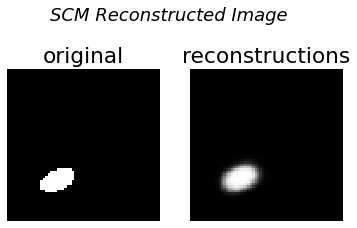

In [25]:
#Sampling prediction on 1000 images
scm_rxs = []
for i in range(1000):
     (scm_rx,scm_ry,_), _= scm.model(scm_cond_noise)
     scm_rxs.append(scm_rx)
compare_to_density(scm_x, torch.cat(scm_rxs))
_ =plt.suptitle("SCM Reconstructed Image", fontsize=18, fontstyle='italic')

### SCM Conditioning

In order to check the causal inference of conditioning is working on SCM, we take a randomly generated image and try to generate reconstructions of this image by passing them through a conditioned model, we achieve this by making use of SCM an object of SCM class.

For this, we first generate a random image and try to capture its label in a dictionary. We then passed the image and its label through the trained VAE object to get it’s mean and variance. Using this mean and variance we created an object of SCM class. 

The label dictionary is passed to the update_noise_svi to capture the noise of the input image. Then a conditioned model is created by applying pyro.condition to the object of SCM class. 

The output noise is then passed to the conditioned model class to regenerate new images. This reconstruction is sampled 1000 times and is displayed using the compare_to_density function.


In [26]:
#Getting original image
scm_x, scm_y = get_specific_data(cuda=True)
scm_cond_data = {}
for i in range(1, 6):
    scm_cond_data["Y_{}".format(i)] = torch.tensor(scm_y[0,i].cpu()).to(torch.float32)
# Pass it through VAE to get q(z|x) => N(mu, sigma)
scm_mu, scm_sigma = vae.encoder.forward(scm_x,vae.remap_y(scm_y))
# Feed these params to our custom SCM
scm = SCM(vae, scm_mu.cpu(), scm_sigma.cpu())
#infer Noise variables from original image
scm_cond_noise = scm.update_noise_svi(scm_cond_data) 
print(scm_cond_data)

{'Y_1': tensor(0.), 'Y_2': tensor(5.), 'Y_3': tensor(17.), 'Y_4': tensor(28.), 'Y_5': tensor(26.)}


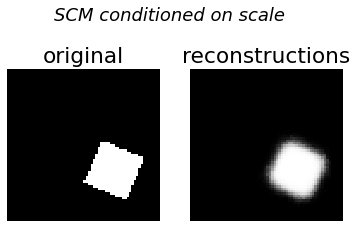

In [27]:
# Conditioning on Scale
conditioned_model = pyro.condition(scm.model, data={
    # "Y_1": torch.tensor(2.),
    "Y_2": torch.tensor(5.),
    # "Y_3": torch.tensor(2.),
    # "Y_4": torch.tensor(5.),
    # "Y_5": torch.tensor(25.),
})
#Sampling prediction on 1000 images
scm_rxs = []
for i in range(1000):
     (scm_rx,scm_ry,_), _= conditioned_model(scm_cond_noise)
     scm_rxs.append(scm_rx)
compare_to_density(scm_x, torch.cat(scm_rxs))
_ =plt.suptitle("SCM conditioned on scale", fontsize=18, fontstyle='italic')

### SCM Counterfactual Interventions

In this causal inference, we try to capture the twin world counterfactual on the dSprite image dataset by making use of exogenous and endogenous variables using an SCM class object. First of all, we generate a random image and then try to capture its label in a dictionary. 


In [28]:
#Getting original image
scm_x, scm_y = get_specific_data(cuda=True)
scm_cond_data = {}
for i in range(1, 6):
    scm_cond_data["Y_{}".format(i)] = torch.tensor(scm_y[0,i].cpu()).to(torch.float32)
# Pass it through VAE to get q(z|x) => N(mu, sigma)
scm_mu, scm_sigma = vae.encoder.forward(scm_x,vae.remap_y(scm_y))
# Feed these params to our custom SCM
scm = SCM(vae, scm_mu.cpu(), scm_sigma.cpu())
#infer Noise variables from original image
scm_cond_noise = scm.update_noise_svi(scm_cond_data) 
print(scm_cond_data)

{'Y_1': tensor(2.), 'Y_2': tensor(2.), 'Y_3': tensor(25.), 'Y_4': tensor(0.), 'Y_5': tensor(22.)}


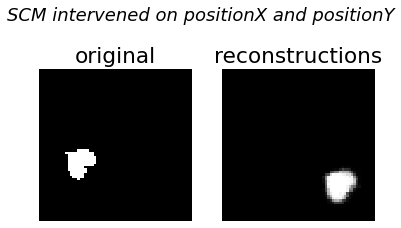

In [29]:
# Intervening on PositionX and PositionY
intervened_model = pyro.do(scm.model, data={
    # "Y_1": torch.tensor(2.),
    # "Y_2": torch.tensor(5.),
    # "Y_3": torch.tensor(2.),
    "Y_4": torch.tensor(31.),
    "Y_5": torch.tensor(31.),
})
#Sampling prediction on 1000 images
scm_rxs = []
for i in range(1000):
     (scm_rx,scm_ry,_), _= intervened_model(scm_cond_noise)
     scm_rxs.append(scm_rx)
compare_to_density(scm_x, torch.cat(scm_rxs))
_ =plt.suptitle("SCM intervened on positionX and positionY", fontsize=18, fontstyle='italic')

### SCM Counterfactuals

##### Original image

Original Labels: tensor([[ 0.,  2.,  5., 27., 17., 14.]], device='cuda:0')


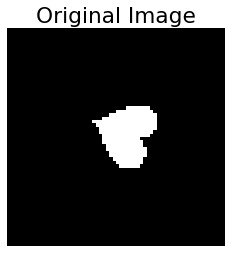

In [30]:
# Generate an instance of dSprites image 
x_original, y_original = get_specific_data(cuda=True)
print('Original Labels:', y_original)
plot_image(x_original)
plt.title("Original Image")
plt.show()

In [31]:
#Creating a conditional variable of Noise variables for the abduction step
original_cond_data = {}
for i in range(1, 6):
    original_cond_data["Y_{}".format(i)] = torch.tensor(y_original[0,i].cpu()).to(torch.float32)
print("original_cond_data:", original_cond_data)

original_cond_data: {'Y_1': tensor(2.), 'Y_2': tensor(5.), 'Y_3': tensor(27.), 'Y_4': tensor(17.), 'Y_5': tensor(14.)}


We applied counterfactual interventions on the input image in 3 steps -
### Abduction step
In this step, we passed the image and its label through the trained VAE object to get it’s mean and variance. Using this mean and variance we created an object of SCM class. The label dictionary is then passed to the update_noise_svi to capture the noise of the input image.


In [32]:
# Pass it through VAE to get q(z|x) => N(mu, sigma)
mu, sigma = vae.encoder.forward(x_original,vae.remap_y(y_original))
# Feed these params to our custom SCM
scm = SCM(vae, mu.cpu(), sigma.cpu())
#infer Noise variables from original image
infer_cond_noise = scm.update_noise_svi(original_cond_data) 
print(infer_cond_noise)

{'N_X': Normal(loc: torch.Size([4096]), scale: torch.Size([4096])), 'N_Z': Normal(loc: torch.Size([50]), scale: torch.Size([50])), 'N_Y_1': Normal(loc: torch.Size([3]), scale: torch.Size([3])), 'N_Y_2': Normal(loc: torch.Size([6]), scale: torch.Size([6])), 'N_Y_3': Normal(loc: torch.Size([40]), scale: torch.Size([40])), 'N_Y_4': Normal(loc: torch.Size([32]), scale: torch.Size([32])), 'N_Y_5': Normal(loc: torch.Size([32]), scale: torch.Size([32]))}


In [33]:
# Printing the inferred noise variables
cf_noise_data = {}
for term, d in infer_cond_noise.items():
  cf_noise_data[term] = d.loc
print(cf_noise_data)

{'N_X': tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]), 'N_Z': tensor([ 2.4133e-04,  5.3015e-04, -8.4128e-06, -2.5820e-04, -9.7703e-04,
         3.8525e-04,  1.0851e-03, -1.7011e-04,  4.9608e-04, -8.8183e-04,
        -6.7435e-04, -2.1240e-04,  2.4444e-04,  1.6723e-04, -8.6025e-04,
         8.3443e-04, -8.1638e-04, -1.0827e-03,  2.1475e-04,  7.3251e-04,
         1.0274e-04,  5.5848e-04, -6.5973e-04, -3.0053e-04, -6.7984e-04,
        -1.4534e-03, -3.2754e-04,  2.8519e-04,  4.7615e-05, -9.5064e-04,
        -5.1816e-04,  3.0870e-04,  8.8582e-04,  3.3348e-04, -1.3739e-04,
         2.6292e-04, -1.0522e-03,  6.2258e-04, -3.3733e-04, -9.1708e-04,
         2.1077e-04, -4.3519e-04,  1.0745e-03,  4.8362e-04,  7.3184e-04,
        -8.0571e-04,  1.0277e-03, -7.6776e-04,  7.4105e-04, -1.9926e-04]), 'N_Y_1': tensor([0.2789, 0.3565, 0.7989]), 'N_Y_2': tensor([0.3770, 0.3985, 0.4302, 0.4825, 0.5662, 0.7117]), 'N_Y_3': tensor([0.3960, 0.4077, 0.4073, 0.4044, 0.4157, 0.4047, 0.4158, 0.4134

###Action Step
In this step, we intervene on the SCM object according to the conditions we want to intervene on and by using the pyro.do method.


In [0]:
# intervening on the SCM model
cf_intervened_model = pyro.do(scm.model, data={
    "Y_1": torch.tensor(1.),
    # "Y_2": torch.tensor(2.),
    # "Y_3": torch.tensor(2.),
    # "Y_4": torch.tensor(5.),
    # "Y_5": torch.tensor(25.),
})

#### Prediction Step
In this final step, we sample the images 1000 times passing the input object noise to the intervened model and generating the output image. We store these 1000 images in a list and pass it to compare_to_density function for image reconstructions.


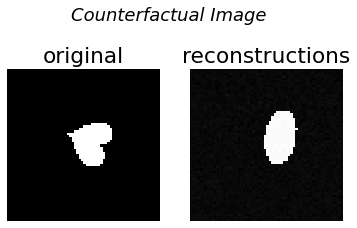

In [40]:
#Predicting single image
(cf_rx,cf_ry,_), _ = cf_intervened_model(infer_cond_noise)
compare_to_density(x_original, cf_rx)
_ =plt.suptitle("Counterfactual Image", fontsize=18, fontstyle='italic')

In [0]:
# Prediction step with Sampling will produce a "Blur" Image as the Mean values are considered.

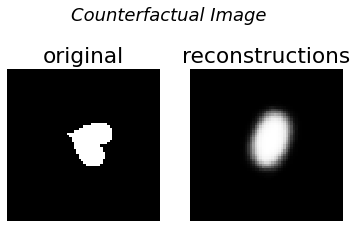

In [41]:
#Sampling prediction on 1000 images
cf_rxs = []
for i in range(1000):
     (cf_rx,cf_ry,_), _= cf_intervened_model(infer_cond_noise)
     cf_rxs.append(cf_rx)
compare_to_density(x_original, torch.cat(cf_rxs))
_ =plt.suptitle("Counterfactual Image", fontsize=18, fontstyle='italic')

### ***Applications of CVAE***
> ### ***Deepfakes***
Generating fake human faces by using counterfactual interventions

> They are synthetic media in which a person in an existing image or video is replaced with someone else’s likeness

> ### ***MusicVAE***
Producing purely synthetic music

>Creating a palette for musical scores with machine learning.
